## Transformações dos dados (colocar dentro da pipeline)

In [114]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp,chi2_contingency
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
sys.path.append(r"C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super")
from utils.classes import FeatureBuilder
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance


In [3]:
dados = pd.read_csv(r'C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super\data\gold\dados_finais_gold.csv')

### Etapas:

- Separação treino e teste
    - Validação da separação dos dados

- Pipeline de transformação e criação de variaveis

- Modelos 
    - Random Forest
    - Regressão Logistica
    - Light GBM

- Avaliação dos modelos
    - Curva ROC AUC

- Estudos de threshold 

- Feature importance, outras análises

#### Transformações necessárias

In [4]:
dados = dados[dados['age']<=100]
dados['became_member_on'] = pd.to_datetime(dados['became_member_on'],errors='coerce')
dados['month'] = dados['became_member_on'].dt.month
dados = dados.drop(columns={'valor_total','valor_total_log'})

#### Treino e Teste

In [5]:
x = dados.drop(columns=['responded'])
y = dados['responded']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
num_cols = x_train.select_dtypes(include=[np.number]).columns

resultados_num = []
for col in num_cols:
    stat, p = ks_2samp(x_train[col], x_test[col])
    resultados_num.append({"variavel": col,"media_train": x_train[col].mean(),"media_test": x_test[col].mean(),"p_ks": p})
    
resultados_num = pd.DataFrame(resultados_num).sort_values("p_ks")

resultados_num

,variavel,media_train,media_test,p_ks
0,age,54.388968,54.117924,0.116141
9,time_total,399.756946,401.467983,0.462115
1,income,65392.908090,65365.546599,0.585306
10,month,6.677853,6.706548,0.758253
3,difficulty,7.737156,7.645231,0.839510
6,mobile,0.897720,0.903179,0.953651
4,duration,6.512805,6.489539,0.973721
8,web,0.798383,0.803007,0.991194
2,reward_offer,4.203813,4.211937,1.000000
5,email,1.000000,1.000000,1.000000


<Figure size 600x400 with 0 Axes>

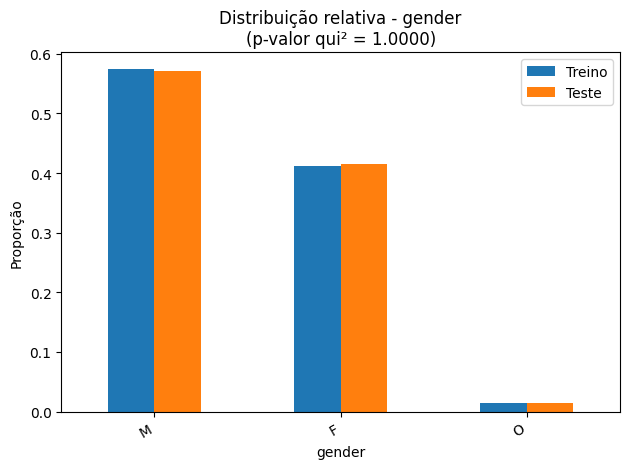

<Figure size 600x400 with 0 Axes>

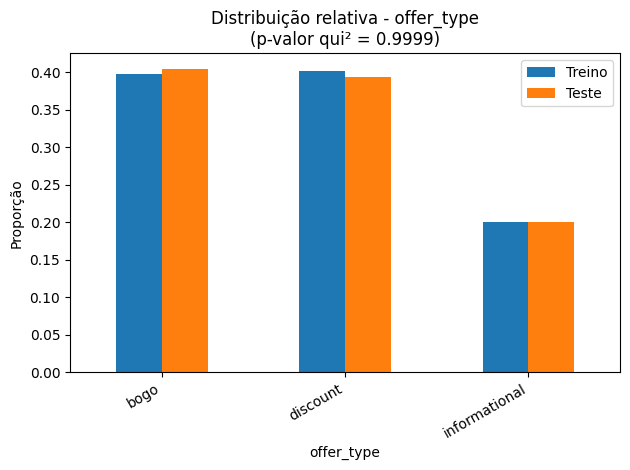

,variavel,p_chi2
1,offer_type,0.999930
0,gender,0.999968


In [7]:
cat_cols = x_train.select_dtypes(exclude=[np.number]).columns
cat_cols = cat_cols.drop(['offer_id','person','became_member_on'], errors='ignore') 
resultados_cat = []
for col in cat_cols:
    tabela = pd.crosstab(x_train[col], x_test[col])
    dist_train = x_train[col].value_counts(normalize=True)
    dist_test = x_test[col].value_counts(normalize=True)
    all_idx = dist_train.index.union(dist_test.index)
    dist_train = dist_train.reindex(all_idx, fill_value=0)
    dist_test = dist_test.reindex(all_idx, fill_value=0)
    chi2, p, dof, _ = chi2_contingency([dist_train, dist_test])
    resultados_cat.append({
        "variavel": col,
        "p_chi2": p
    })

    plt.figure(figsize=(6,4))
    df_plot = pd.DataFrame({
        "Treino": dist_train,
        "Teste": dist_test
    })
    df_plot.plot(kind="bar")
    plt.title(f"Distribuição relativa - {col}\n(p-valor qui² = {p:.4f})")
    plt.ylabel("Proporção")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


resultados_cat = pd.DataFrame(resultados_cat).sort_values("p_chi2")
resultados_cat


#### Modelo Random Forest

In [55]:
dados_id = ['person', 'offer_id']

feature_pipeline = Pipeline( steps=[
    ('feature_engineering', FeatureBuilder(map_gender=True, drop_raw=True))
])

numeric_transformer = Pipeline(steps=[
    ('inputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('inputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_sel = lambda X: X.select_dtypes(include=['number']).columns.difference(dados_id)
cat_sel = lambda X: X.select_dtypes(exclude=['number']).columns.difference(dados_id)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_sel),
        ('cat', categorical_transformer, cat_sel),
        ('drop_ids', 'drop', dados_id)
    ],
    remainder='drop'
)

prep_pipe = Pipeline(steps=[
    ('fe', feature_pipeline),
    ('pre', preprocessor)
])

model_base_clf = RandomForestClassifier(random_state=42)


pipe_model = Pipeline(steps=[
    ('prep',prep_pipe),
    ('model', model_base_clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe_model,
    x_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Scores por fold:", scores)
print("Média:", scores.mean())
print("Desvio padrão:", scores.std())


Scores por fold: [0.7951311  0.79823582 0.80893046 0.80318231 0.79449955]
Média: 0.7999958471448245
Desvio padrão: 0.005421319850300355


In [56]:
pipe_model.fit(x_train, y_train)
y_pred = pipe_model.predict(x_test)
y_proba = pipe_model.predict_proba(x_test)[:, 1]
acuracia_rand_fores = accuracy_score(y_test, y_pred)
roc_rand_fores = roc_auc_score(y_test, y_proba)

fpr1, tpr1, _ = roc_curve(y_test, y_proba)
auc1 = auc(fpr1, tpr1)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Acurácia: 0.7300063400054343
ROC AUC: 0.8016906487498578

Matriz de Confusão:
 [[3660 1794]
 [1187 4400]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.76      0.67      0.71      5454
         1.0       0.71      0.79      0.75      5587

    accuracy                           0.73     11041
   macro avg       0.73      0.73      0.73     11041
weighted avg       0.73      0.73      0.73     11041



#### Modelo Regressão Logistica

In [57]:
model_reg = LogisticRegression(
    solver='saga',
    max_iter = 100,
    n_jobs=None
)

pipe_log = Pipeline(steps=[
    ('prep', prep_pipe),
    ('model_reg_log', model_reg)

])

param_grid = {
    'model_reg_log__penalty':['l1','l2'],
    'model_reg_log__C' : [0.01,0.1,0.5,1,5]
}

grid = GridSearchCV(
    pipe_log,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid.fit(x_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor score:", grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'model_reg_log__C': 0.5, 'model_reg_log__penalty': 'l1'}
Melhor score: 0.8364644207357793


In [58]:
best_model = grid.best_estimator_
y_proba_test = best_model.predict_proba(x_test)[:, 1]
y_pred_test = best_model.predict(x_test)
acuracia_reg_log =accuracy_score(y_test, y_pred_test)
roc_reg_log = roc_auc_score(y_test, y_proba_test)

fpr2, tpr2, _ = roc_curve(y_test, y_proba_test)
auc2 = auc(fpr2, tpr2)

print("Acurácia:", accuracy_score(y_test, y_pred_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test))

print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_test))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_test))

Acurácia: 0.7614346526582737
ROC AUC: 0.8359209809770428

Matriz de Confusão:
 [[3604 1850]
 [ 784 4803]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.82      0.66      0.73      5454
         1.0       0.72      0.86      0.78      5587

    accuracy                           0.76     11041
   macro avg       0.77      0.76      0.76     11041
weighted avg       0.77      0.76      0.76     11041



#### Modelo LightGBM

In [59]:
model_lgbm = lightgbm.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    class_weight="balanced",  
    n_jobs=-1
)

pipe_model_lgbm = Pipeline(steps=[
    ('prep', prep_pipe),
    ('model', model_lgbm)
])

param_grid_2 = {
    'model__n_estimators': [50, 100, 250,500],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [5, 15, 30, 60, 100, 150],
    'model__max_depth': [5, 20, 30],
}

grid_2 = GridSearchCV(
    estimator=pipe_model_lgbm,
    param_grid=param_grid_2,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True 
)
grid_2.fit(x_train, y_train) 


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Number of positive: 22345, number of negative: 21818
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 44163, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,estimator,Pipeline(step...e='binary'))])
,param_grid,"{'model__learning_rate': [0.01, 0.05, ...], 'model__max_depth': [5, 20, ...], 'model__n_estimators': [50, 100, ...], 'model__num_leaves': [5, 15, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,steps,"[('fe', ...), ('pre', ...)]"


In [60]:
print(f"Melhor AUC-CV: {grid_2.best_score_:.4f}")
print("Melhores parâmetros:", grid_2.best_params_)

Melhor AUC-CV: 0.8420
Melhores parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 500, 'model__num_leaves': 5}


In [61]:
best_model_2 = grid_2.best_estimator_
y_proba_test_2 = best_model_2.predict_proba(x_test)[:, 1]
y_pred_test_2 = best_model_2.predict(x_test)

acuracia_light = accuracy_score(y_test, y_pred_test_2)
roc_light = roc_auc_score(y_test, y_proba_test_2)

fpr3, tpr3, _ = roc_curve(y_test, y_proba_test_2)
auc3 = auc(fpr3, tpr3)

print("Acurácia:", accuracy_score(y_test, y_pred_test_2))
print("ROC AUC:", roc_auc_score(y_test, y_proba_test_2))

print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_test_2))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_test_2))

Acurácia: 0.765872656462277
ROC AUC: 0.8413954410774291

Matriz de Confusão:
 [[3666 1788]
 [ 797 4790]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.82      0.67      0.74      5454
         1.0       0.73      0.86      0.79      5587

    accuracy                           0.77     11041
   macro avg       0.77      0.76      0.76     11041
weighted avg       0.77      0.77      0.76     11041



In [62]:
resultados = pd.DataFrame({
    'modelos':['Random_forest', 'Regressao_logistica','LightGBM'],
    'best_score_train':[scores.mean(),grid.best_score_,grid_2.best_score_],
    'roc_auc_test':[roc_rand_fores,roc_reg_log,roc_light],
    'acuracia_test': [acuracia_rand_fores,acuracia_reg_log,acuracia_light]
})

In [63]:
resultados

,modelos,best_score_train,roc_auc_test,acuracia_test
0,Random_forest,0.799996,0.801691,0.730006
1,Regressao_logistica,0.836464,0.835921,0.761435
2,LightGBM,0.842039,0.841395,0.765873


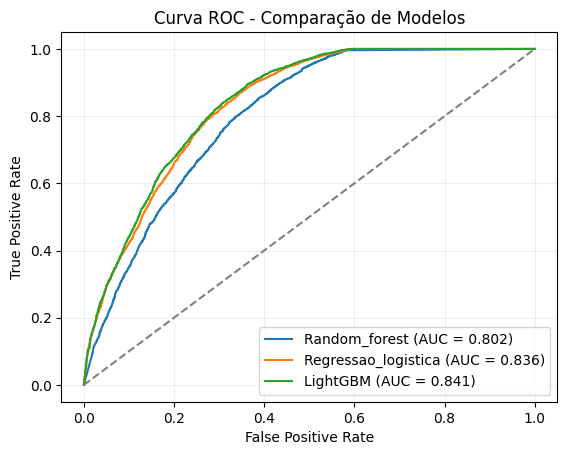

In [72]:
plt.plot(fpr1, tpr1, label=f"{'Random_forest'} (AUC = {auc1:.3f})")
plt.plot(fpr2, tpr2, label=f"{'Regressao_logistica'} (AUC = {auc2:.3f})")
plt.plot(fpr3, tpr3, label=f"{'LightGBM'} (AUC = {auc3:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparação de Modelos")
plt.legend()
plt.grid(alpha=0.2)

plt.show()

#### Analise Features e Threshold

<!-- # Validação Cruzada — Imputação de Renda (income)

## O que foi feito

1) **Definimos a variável-alvo (target)**  
   - Para cada cliente (`person`), marcamos `1` se ele **completou ao menos uma oferta** (`offer_completed`) e `0` caso contrário.  
   - Isso transforma o problema em **classificação binária** (completou vs. não completou).

2) **Juntamos o alvo com o perfil do cliente**  
   - Cruzamos com `df_profile_clean` para ter as features **`age`** e **`income`** (renda).

3) **Criamos duas versões do dataset** para testar o *tratamento de valores ausentes*:
   - **Sem imputação**: removemos linhas onde `income` era nulo (`NaN`).  
   - **Com imputação**: preenchemos `income` faltante com a **mediana** da renda.

4) **Treinamos e avaliamos um modelo igual nos dois cenários**  
   - Modelo: **RandomForestClassifier** (padrão, `random_state=42`).  
   - Validação: **5-fold Stratified Cross-Validation** (mantém a proporção de classes em cada dobra).  
   - Métrica: **accuracy** (acertos/total) em cada dobra; depois calculamos a **média**.

---

## Resultados

- **Sem imputação (descartando NaN)**  
  Acurácias por dobra: `[0.7514, 0.7518, 0.7538, 0.7535, 0.7514]`  
  **Média:** **0.7524**

- **Com imputação (mediana)**  
  Acurácias por dobra: `[0.7491, 0.7379, 0.7347, 0.7403, 0.7376]`  
  **Média:** **0.7399**

---

- A **validação cruzada** estima o desempenho **fora da amostra** (generalização) e reduz o risco de avaliar o modelo apenas em um único “corte” dos dados.
- O modelo **sem imputação** teve **accuracy médio ~1,25 p.p. maior** (*0,7524 vs 0,7399*).  
- Como o **modelo** e a **validação** foram idênticos nos dois cenários, a diferença se deve ao **tratamento de valores ausentes em `income`**.

---

## Conclusão 

- **Para este alvo e esse conjunto de features**, **descartar** as linhas sem `income` rendeu melhor desempenho do que **imputar por mediana**.  
- Possíveis razões:
  - As ausências de `income` **não são aleatórias** (o que a mediana não captura), introduzindo ruído.  
  - Preencher com um valor “típico” (mediana) **achata diferenças** entre clientes e reduz o sinal preditivo.

**Decisão prática:** para esta tarefa, **manter a versão sem imputação de `income`** foi **ligeiramente melhor**.  
(Anote no relatório que você testou os dois tratamentos e comparou com validação cruzada.)

--- -->

